# Analyse data
Do some data wrangling

In [1]:
import pandas as pd
import json
from pathlib import Path
import utils
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
csv_path = Path('../export/csv_for_infographics')

In [3]:
df_votum_raw = pd.concat([
    pd.read_csv(Path('../export/votum/votum_0.csv')),
    pd.read_csv(Path('../export/votum/votum_1.csv'))
])

# Remove non members (mostly former members who are now in the Regierungsrat)
df_votum_raw = df_votum_raw[df_votum_raw.ismember == True]

# Typecast
df_votum_raw['sitzung_date'] = pd.to_datetime(df_votum_raw['sitzung_date'])

# Remove empty texts
df_votum_raw = df_votum_raw[df_votum_raw.text.notna()]

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_votum_raw['year'] = df_votum_raw['sitzung_date'].dt.year
df_votum_raw['month'] = df_votum_raw['sitzung_date'].dt.month
df_votum_raw['session'] = df_votum_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

print("Stand: %s" % df_votum_raw['sitzung_date'].max())

Stand: 2022-03-28 00:00:00


## How many times did m/w talk?

In [4]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum_pivot = pd.pivot_table(df_votum, index='session', columns='geschlecht', values='name', aggfunc='count').reset_index()

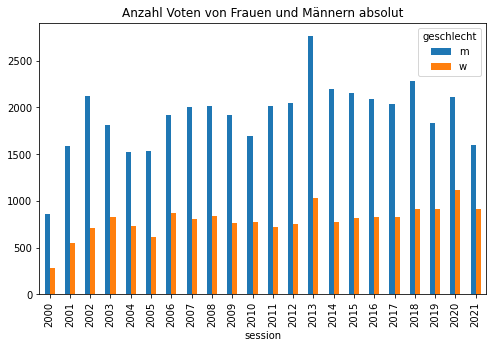

In [5]:
# Do it absolut, plain, in your face way without thinking, but writing a very long comment. Actually this is just a test if someone reads my scripts. If so, write a hello at simon.huwiler@nzz.ch
df_votum_pivot[['m', 'w', 'session']].set_index('session').plot.bar(figsize=(8, 5), title='Anzahl Voten von Frauen und Männern absolut')

# Store as CSV
df_votum_pivot[['m', 'w', 'session']].set_index('session').to_csv(csv_path / 'voten_m_w_absolut.csv')

[csv Voten m/w absolut herunterladen](../export/csv_for_infographics/voten_m_w_absolut.csv)

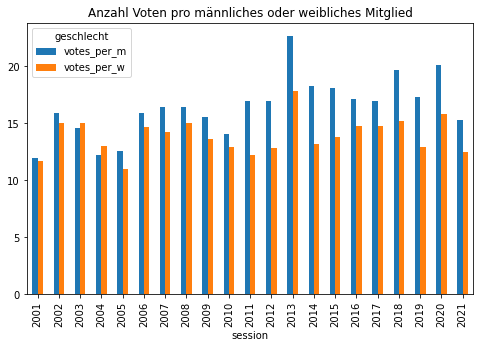

In [6]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df_rat = pd.pivot_table(df, index='year', columns='geschlecht', values='name', aggfunc='count').reset_index()

# Concat
df_res = df_votum_pivot.merge(df_rat, left_on = 'session', right_on = 'year', suffixes=('_v', '_r'))

# Votes per w/m
df_res['votes_per_m'] = round(df_res['m_v'] / df_res['m_r'], 1)
df_res['votes_per_w'] = round(df_res['w_v'] / df_res['w_r'], 1)

df_res.set_index('session', inplace=True)

df_res.drop(columns=['year'], inplace=True)

df_res[['votes_per_m', 'votes_per_w']].plot.bar(figsize=(8, 5), title='Anzahl Voten pro männliches oder weibliches Mitglied')

# Store as CSV
df_res[['votes_per_m', 'votes_per_w']].to_csv(csv_path / 'voten_m_w_relative.csv')


[csv Voten m/w relativ herunterladen](../export/csv_for_infographics/voten_m_w_relative.csv)

## Unterschiedliche Textlänge?
Erkenntnis: Frauen und Männer reden gleich lange. Wohl wegen begrenzter Redezeit?

In [7]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.reset_index(drop=True)

# Count words
#df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x.split()))
df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x))

df_votum = df_votum.groupby('geschlecht').agg({
    'wordcount': 'sum',
    'name': 'count'
})

df_votum['l'] = round(df_votum['wordcount'] / df_votum['name'])

df_votum

,wordcount,name,l
geschlecht,,,
m,83525642,42102,1984.0
w,34821679,17394,2002.0


## The Speakers...

<AxesSubplot:title={'center':'Am meisten und wenigsten Voten 2021'}, ylabel='name'>

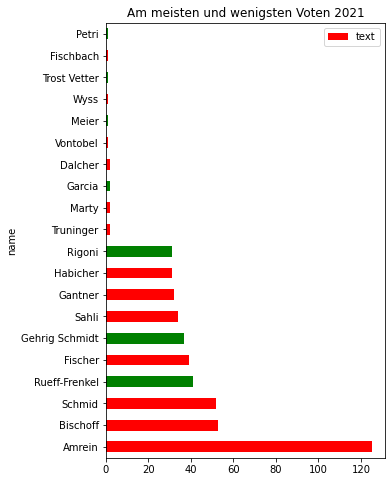

In [8]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session == 2021]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum = pd.concat([df_votum.head(10), df_votum.tail(10)])

c = list(df_votum['geschlecht'].apply(lambda x: 'red' if x == 'm' else 'green'))
df_votum.plot(kind='barh', x='name', y='text', color=c, figsize=(5, 8), title='Am meisten und wenigsten Voten 2021')

#df_votum.head()

In [9]:
df_votum.to_csv(csv_path / 'top_flop_speakers_2021.csv', index=False)
df_votum

,name,vorname,geschlecht,text
6,Amrein,Hans-Peter,m,125
14,Bischoff,Markus,m,53
134,Schmid,Stefan,m,52
123,Rueff-Frenkel,Sonja,w,41
43,Fischer,Benjamin,m,39
51,Gehrig Schmidt,Sonja,w,37
126,Sahli,Manuel,m,34
49,Gantner,Alex,m,32
59,Habicher,Lorenz,m,31
119,Rigoni,Silvia,w,31


[csv top/flop speakers herunterladen](../export/csv_for_infographics/top_flop_speakers_2021.csv)

## Frauen im Durchschnitt

In [10]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session >= 2018]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

# Nur Frauen
df_votum = df_votum[df_votum.geschlecht == 'w']

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum['_name'] = df_votum.apply(lambda row: "%s %s" % (row['vorname'], row['name']), axis=1)

df_votum = df_votum[['_name', 'text']]

df_votum.rename(columns={'text': 'Anzahl Voten'}, inplace=True)

df_votum = df_votum.set_index('_name')

median = df_votum['Anzahl Voten'].median()

df_votum[df_votum['Anzahl Voten'].between(median - 2, median + 2)]

,Anzahl Voten
_name,
Angie Romero,32
Jacqueline Peter,32
Andrea Gisler,31
Judith Bellaïche,31
Karin Joss,31
Sandra Bossert,31
Leandra Columberg,29


<AxesSubplot:title={'center':'Anzahl Voten'}, xlabel='_name'>

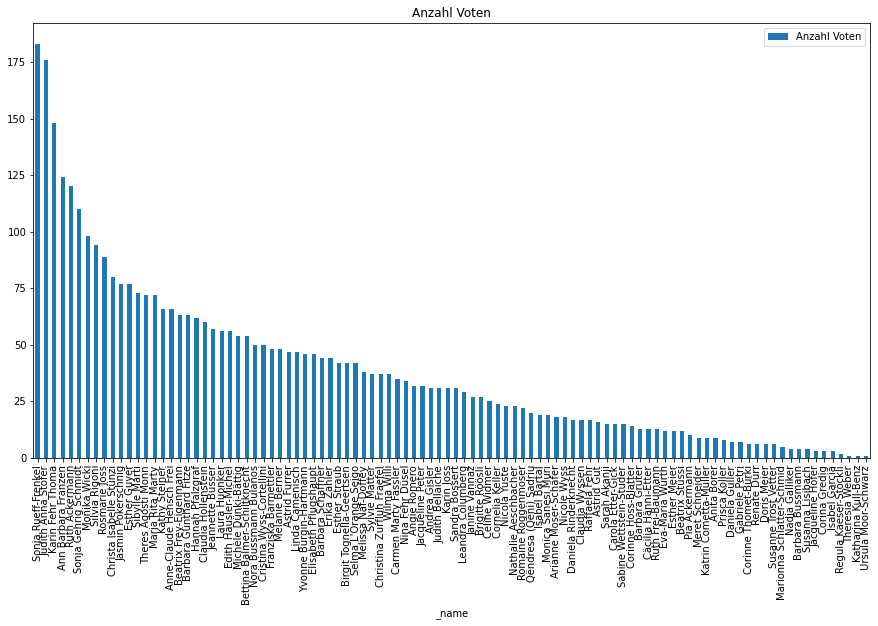

In [11]:
df_votum.plot.bar(figsize=(15, 8), title='Anzahl Voten')

In [12]:
print("Mean: %s" % df_votum['Anzahl Voten'].mean())
print("Median: %s" % df_votum['Anzahl Voten'].median())

Mean: 38.61
Median: 31.0


## Talking Parties...

<AxesSubplot:title={'center':'Welche Partei spricht wie oft (absolut)?'}, xlabel='partei'>

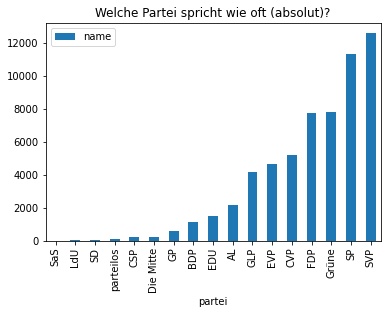

In [13]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).sort_values('name')
df_votum.plot.bar(title='Welche Partei spricht wie oft (absolut)?')

<AxesSubplot:title={'center':'Welche Partei wie oft spricht, nach Parteistärke'}>

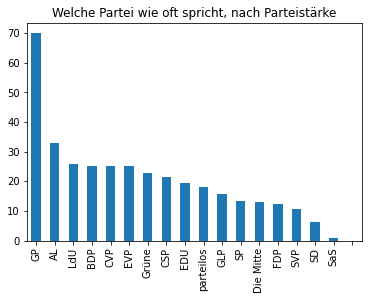

In [14]:
# Relative per strength
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df = pd.pivot_table(df, columns='party', values='name', aggfunc='count').reset_index(drop=True)
df.loc[0, 'name'] = 'members'

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).T.reset_index(drop=True)
df_votum.loc[0, 'name'] = 'votes'

# Combine both datasets, set index and transform
df = pd.concat([df, df_votum])
df = df.set_index('name').T
df = df.fillna(0)

# Calculate Vote per Member
df['per_member'] = round(df['votes'] / df['members'], 1)

df.sort_values('per_member', ascending=False)['per_member'].plot.bar(title='Welche Partei wie oft spricht, nach Parteistärke')

In [15]:
df.sort_values('per_member', ascending=False)

name,members,votes,per_member
GP,8.0,559.0,69.9
AL,66.0,2173.0,32.9
LdU,1.0,26.0,26.0
BDP,44.0,1115.0,25.3
CVP,206.0,5203.0,25.3
EVP,184.0,4660.0,25.3
Grüne,344.0,7809.0,22.7
CSP,11.0,236.0,21.5
EDU,78.0,1510.0,19.4
parteilos,4.0,72.0,18.0


## Wie findet eine Debatte statt?

In [16]:
# fix Date: If "Vormittag" or "Nachmittag", add Time
df_votum = df_votum_raw.copy()

def add_date(row):
    if 'Vormittag' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=8)

    if 'Nachmittag' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=14)

    if 'Abend' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=19)

    if 'Nacht' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=23)

    return row['sitzung_date']

df_votum['sitzung_date2'] = df_votum.apply(add_date, axis=1)

In [17]:
records = []
for date in df_votum['sitzung_date2'].unique():
    df = df_votum[df_votum.sitzung_date2 == date].reset_index(drop=True)
    for i, row in df.iterrows():
        t = 'the king' if row['funktion'] in ['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'] else row['geschlecht']
        records.append({
            'sitzung_date': date,
            'i': i,
            'type': t,
            'name': "%s %s" % (row['vorname'], row['name'])
        })

In [18]:
# Test: Replace Date with index
df_sitzung = pd.DataFrame(records)

for i, d in enumerate(df_sitzung.sitzung_date.unique()):
    df_sitzung.loc[df_sitzung.sitzung_date == d, 'group'] = i

In [19]:
# Filter, if needed
df_sitzung = df_sitzung[df_sitzung.sitzung_date >= '2016-05-01']

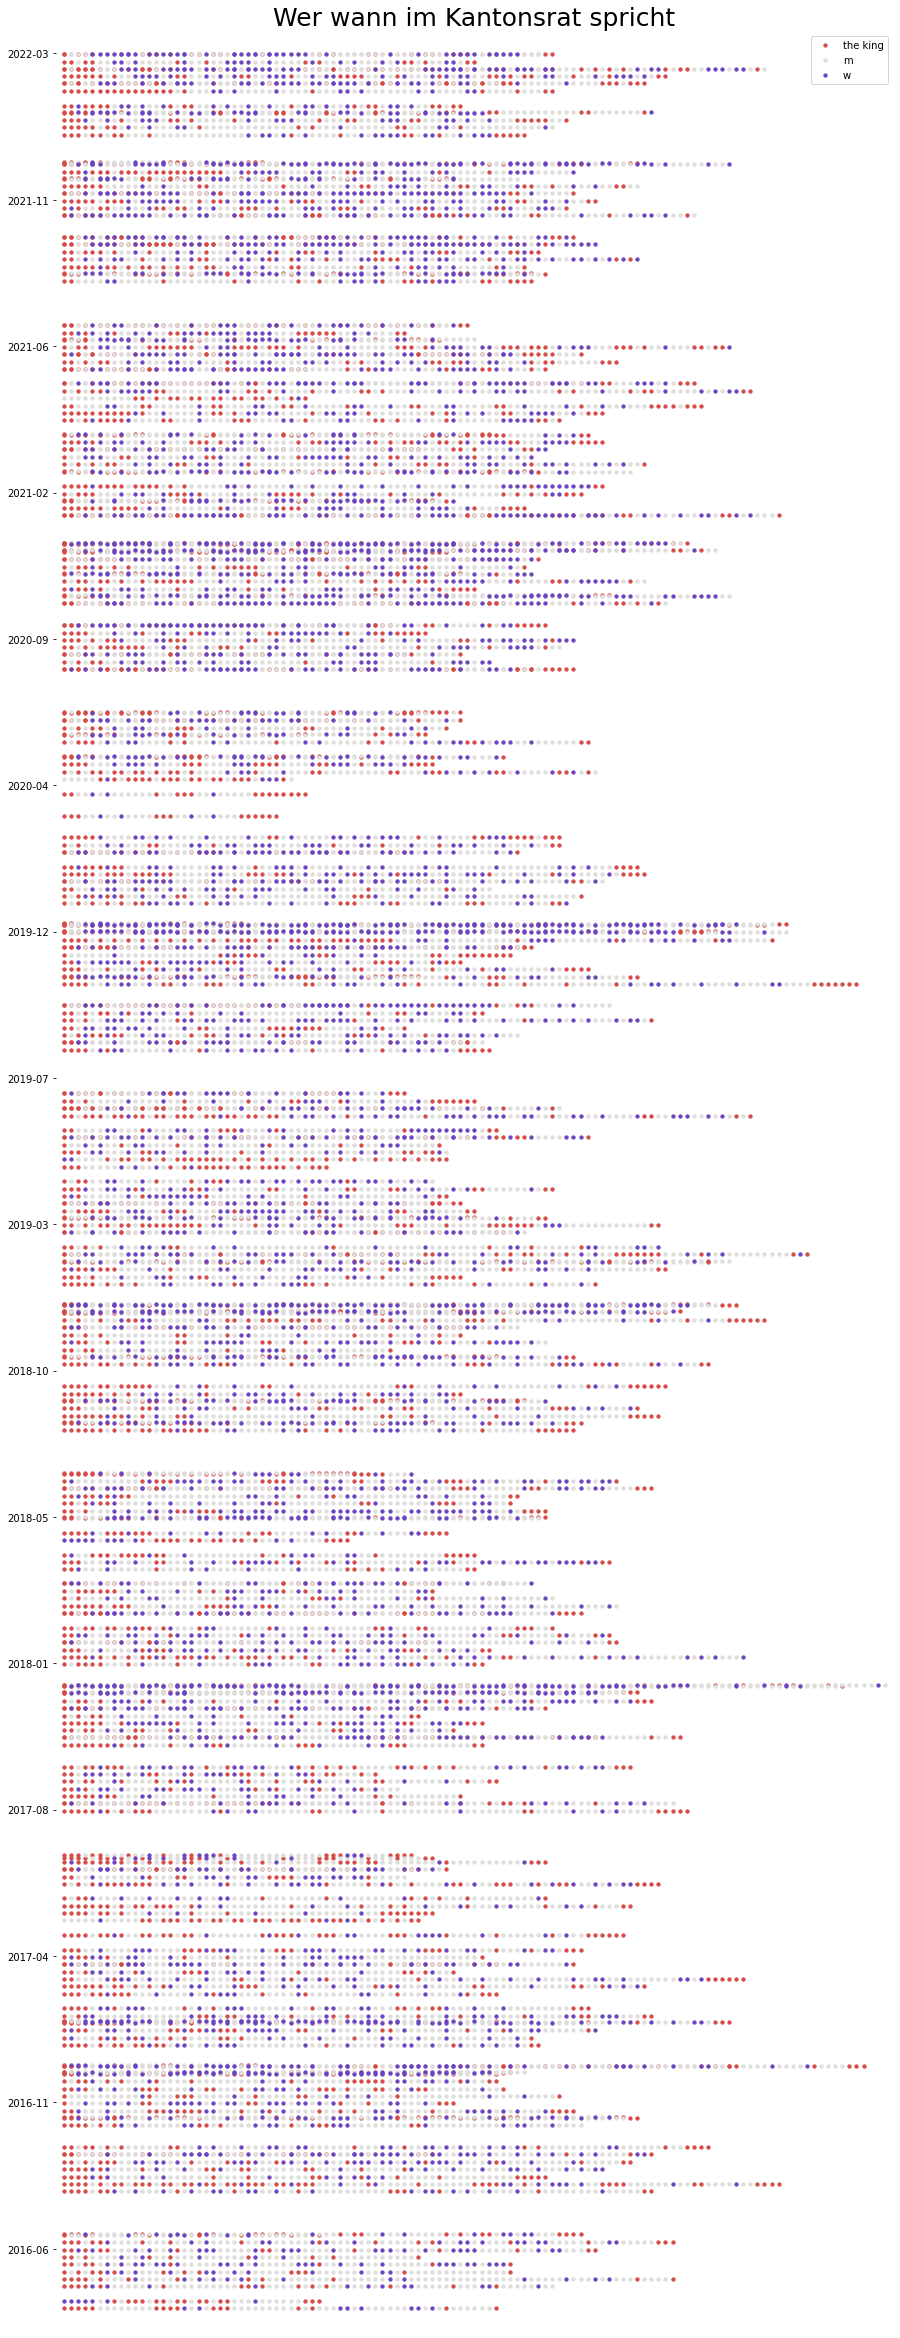

In [20]:
#df_sitzung = pd.DataFrame(records)

size_x = 15
fig, ax = plt.subplots(figsize=(size_x, size_x * 1.41 * 2))
ax.margins(0.05)
for t in df_sitzung.type.unique():
    df = df_sitzung[df_sitzung.type == t]
    #c = '#d64b47' if t == 'the king' else '#24b39c' if t == 'm' else '#6c43c0'
    c = '#d64b47' if t == 'the king' else '#dedddc' if t == 'm' else '#6c43c0'
    #ax.plot(df['i'], df['group'], marker='o', linestyle='', ms=3.3, label=t, color=c)
    ax.plot(df['i'], df['sitzung_date'], marker='o', linestyle='', ms=3.3, label=t, color=c)

ax.legend(numpoints=1, loc='upper right')

ax.yaxis.set_major_locator(mdates.WeekdayLocator(interval=20))
ax.yaxis.set_major_formatter(DateFormatter("%Y-%m"))

plt.title("Wer wann im Kantonsrat spricht", fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.margins(0.01)

#plt.show()
plt.savefig(Path('../export/plots/dotplot.png'), dpi=200, bbox_inches='tight')

#df_sitzung.head()

## The same but interactive

In [21]:
import plotly.express as px
#df_sitzung = pd.DataFrame(records)

fig = px.scatter(df_sitzung,
    x="i", y="group",
    color="type",
    hover_data={"sitzung_date": "|%Y-%m-%d %H:00"},
    width=1200, height=2200,
    color_discrete_sequence=["#d64b47", "#24b39c", "#6c43c0"])

# Change marker size
fig.update_traces(marker=dict(size=4), selector=dict(mode='markers'))

fig.show()

## Wo Frauen wenig/viel gesprochen haben und bei welchen Themen
* Top 10 Sitzungen, bei denen Frauen/Männer am meisten gesprochen haben.
* Von diesen Sitzungen Sitzungsprotokolle exportieren

In [22]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum['sitzung_date'] = df_votum.apply(add_date, axis=1)

# Pivot
df_votum = pd.pivot_table(df_votum, index = 'sitzung_date', columns='geschlecht', values='name', aggfunc='count')

df_votum['v'] = round(df_votum['m'] / df_votum['w'], 2)
df_votum['sum'] = df_votum.sum(axis=1)

df_votum = df_votum.sort_values('v')

In [23]:
df_traktanden = pd.read_csv(Path('../export/traktanden.csv'))
df_traktanden['sitzung'] = pd.to_datetime(df_traktanden['sitzung'])

df_votum_trak = df_votum[df_votum.index >= df_traktanden['sitzung'].min()]

### Bei diesen Traktanden haben *Frauen* am meisten gesprochen

In [24]:
# Traktanden bei Top 10 w
dates = list(df_votum_trak[df_votum_trak.v <= 1].head(10).index)
list(df_traktanden[df_traktanden.sitzung.isin(dates)]['titel'])

['Genehmigung des Jahresberichtes der Universität Zürich für das Jahr 2018',
 'Genehmigung Jahresbericht der Zürcher Fachhochschule für das Jahr 2018',
 'Volksinitiative «für ein Musikschulgesetz»',
 'Mobilitätsfinanzierung nach dem Verursacherprinzip',
 'Koordination und Förderung im Bereich der Kinder- und Jugendrechte',
 'Tätigkeitsbericht Ombudsmann 2019',
 'Tätigkeitsbericht Datenschutzbeauftragter 2019',
 'Tracing oder Virus – wer hat die Nase vorn?',
 'Umgang des Kanton Zürichs mit der besonderen Lage',
 'Jahresbericht Universitätsspital Zürich und Bericht über die Umsetzung der Eigentümerstrategie für das Jahr 2019',
 'Gesundheitsgesetz (GesG), Änderung, Aus- und Weiterbildungsverpflichtung',
 'Spitalplanungs- und Finanzierungsgesetz (SPFG), Änderung, Anforderungen für Leistungsaufträge',
 'Untersuchung zu besonderen Vorkommnissen an mehreren Kliniken des Universitätsspitals Zürich (USZ)',
 'Entkoppelung Lehrstuhl/Klinikdirektion / Umsetzung Bericht USZ KR-Nr. 58/2021 (1)',
 'N

### Bei diesen Traktanden haben *Männer* am meisten gesprochen

In [25]:
# Traktanden bei Top 10 m
dates = list(df_votum_trak[df_votum_trak.v >= 1].tail(10).index)
list(df_traktanden[df_traktanden.sitzung.isin(dates)]['titel'])

['Wahl der Aufsichts- und Sachkommissionen',
 'Wahl der Geschäftsleitung des Kantonsrates für das Amtsjahr 2019/2020',
 'Erwahrung der Ergebnisse der Erneuerungswahl der Mitglieder des Kantonsrates vom 24.März 2019 für die Amtsdauer 2019–2023',
 'Bauprogramm der Staatsstrassen für die Jahre 2020-2022',
 'Strassengesetz § 14 Abs. 2, Zonen mit reduziertem Tempo',
 'Strassengesetz § 30',
 'Bundesrechtswidrige Bestimmung im Strassengesetz',
 'Anpassung der kantonalen Signalisationsverordnung',
 'Verordnung über die Funktionsfähigkeit der Gemeindeorgane während der Corona-Pandemie',
 'Verordnung über den Fristenstillstand bei kantonalen und kommunalen Volksbegehren und Wahlen während der Corona-Pandemie',
 'Gesundheitsgesetz (GesG)',
 'Genehmigung von Teilen der Verkehrserschliessungsverordnung (VErV)',
 'Volksschulgesetz (VSG) und Lehrpersonalgesetz (LPG)',
 'Gesetz über die Nutzung des Untergrundes (GNU)',
 'Abrechnung des Kredites für den Neubau Bezirksverwaltung Dietikon',
 'Eintritt ne